In [2]:
# importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# importing datasets
df_sales=pd.read_csv('/Users/apple/Documents/Projects/Storage sales/Train.csv')
df_sales_test=pd.read_csv('/Users/apple/Documents/Projects/Storage sales/Test.csv')


# viewing the dataframe
df_sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
print(f'The shape of the training dataset is: {df_sales.shape}')

The shape of the training dataset is: (8523, 12)


In [6]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
print(f'The shape of the testing dataset is: {df_sales_test.shape}')

The shape of the testing dataset is: (5681, 11)


In [9]:
df_sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


# Data Preprocessing
Within this section, we will perform the following tasks:

 ### Data Cleaning:
   1)Replacing missing numerical values with the mean value of the corresponding column.
   
   2)Substituting missing categorical data with the mode value of the respective category.

In [11]:
# replacing null with mean values
df_sales['Item_Weight'].replace(np.nan, df_sales['Item_Weight'].mean(), inplace=True)

# replacing null with mode values
df_sales['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [12]:
# creating a pivot table
mode_of_outlet_size=pd.pivot_table(data=df_sales, values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [13]:
# replacing the values
missing_outlet_size=df_sales['Outlet_Size'].isnull()
missing_outlet_size

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [14]:
# replacing the missing values using mode imputation strategy
df_sales.loc[missing_outlet_size,'Outlet_Size']=df_sales.loc[missing_outlet_size,'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])

In [16]:
# checking for Null values
df_sales.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [18]:
# removing na values in the testing data
df_sales_test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [19]:
# dropping all the rows from the test dataset that are missing
df_sales_test.dropna(inplace=True)
df_sales_test.shape

(3099, 11)

In [20]:
# for all the categorical data we will be seeing the unique values in each column

# creating a list of categorical columns
cat_col=[col for col in df_sales.columns if df_sales[col].dtype==np.dtype('O')]

# finding unique values in categorical columns
for col in df_sales[cat_col]:
    print('\n')
    print(f'The unique values in {col} column are:')
    print(df_sales[col].value_counts())



The unique values in Item_Identifier column are:
FDG33    10
FDW13    10
NCF42     9
FDX31     9
FDW26     9
         ..
DRF48     1
FDN52     1
FDO33     1
FDY43     1
FDE52     1
Name: Item_Identifier, Length: 1559, dtype: int64


The unique values in Item_Fat_Content column are:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


The unique values in Item_Type column are:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


The unique values in Outlet_Identifier co

In [21]:
# replacing values
df_sales['Item_Fat_Content'].replace({'LF': 'Low Fat','low fat': 'Low Fat','reg': 'Regular'}, inplace=True)

In [22]:
# checking the value counts in the item weight column
df_sales['Item_Fat_Content'].value_counts(0)

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [23]:
# now standardizing the testing set similarly
# replacing values
df_sales_test['Item_Fat_Content'].replace({'LF': 'Low Fat','low fat': 'Low Fat','reg': 'Regular'}, inplace=True)

# checking the value counts in the item weight column
df_sales_test['Item_Fat_Content'].value_counts(0)

Low Fat    2008
Regular    1091
Name: Item_Fat_Content, dtype: int64

## Data Analysis

In [24]:
#This code snippet configures the plotting styles of the seaborn library to enhance the visual aesthetics of the generated graphs.
sns.set()

# getting some numerical insights on the data
df_sales.describe()



,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [25]:
# finding the correlations of the numerical values
corr_table=df_sales.corr()
corr_table.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.012049,0.024756,-0.008301,0.011550
Item_Visibility,-0.012049,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024756,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.008301,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.011550,-0.128625,0.567574,-0.049135,1.000000


Text(0.5, 1.0, 'Heatmap showing the correlation between the different columsn of the dataframe')

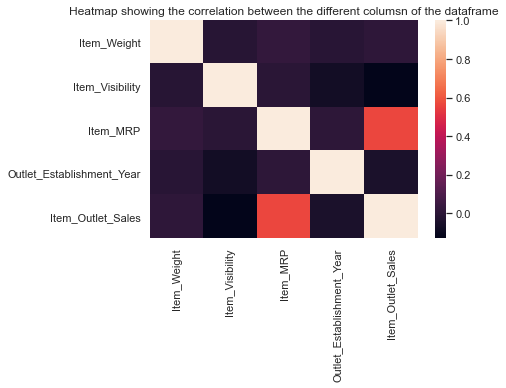

In [26]:
# plotting the correlation of different columns using a heatmap
sns.heatmap(corr_table)
plt.title('Heatmap showing the correlation between the different columsn of the dataframe')

Based on the heatmap presented above, it is apparent that there is a lack of significant positive or negative correlation among the numerical columns. This conclusion is drawn from observing that the correlation values predominantly cluster around zero, rather than approaching values close to 1 or -1.

#### Distribution of items

Text(0.5, 1.0, 'Distribution of Item Weights')

<Figure size 432x432 with 0 Axes>

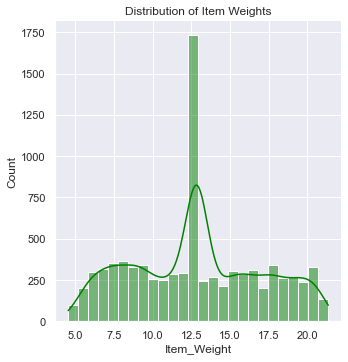

In [27]:
plt.figure(figsize=(6,6))
sns.displot(df_sales['Item_Weight'], kde=True, color='green')
plt.title('Distribution of Item Weights')


Text(0.5, 1.0, 'Item fat content distribution')

<Figure size 432x432 with 0 Axes>

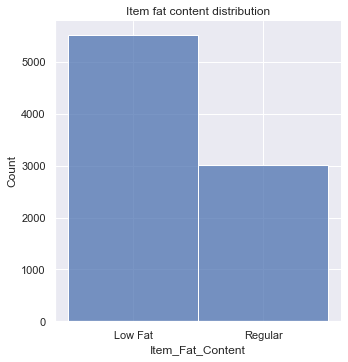

In [28]:
plt.figure(figsize=(6,6))
sns.displot(x=df_sales.Item_Fat_Content)
plt.title('Item fat content distribution')

Text(0.5, 1.0, 'Item Visibility distribution')

<Figure size 432x432 with 0 Axes>

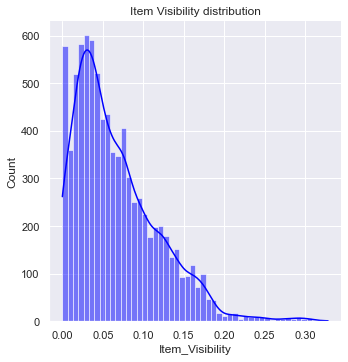

In [29]:
plt.figure(figsize=(6,6))
sns.displot(df_sales['Item_Visibility'], color='blue', kde=True)
plt.title('Item Visibility distribution')

Text(0.5, 1.0, 'Item Type distribution')

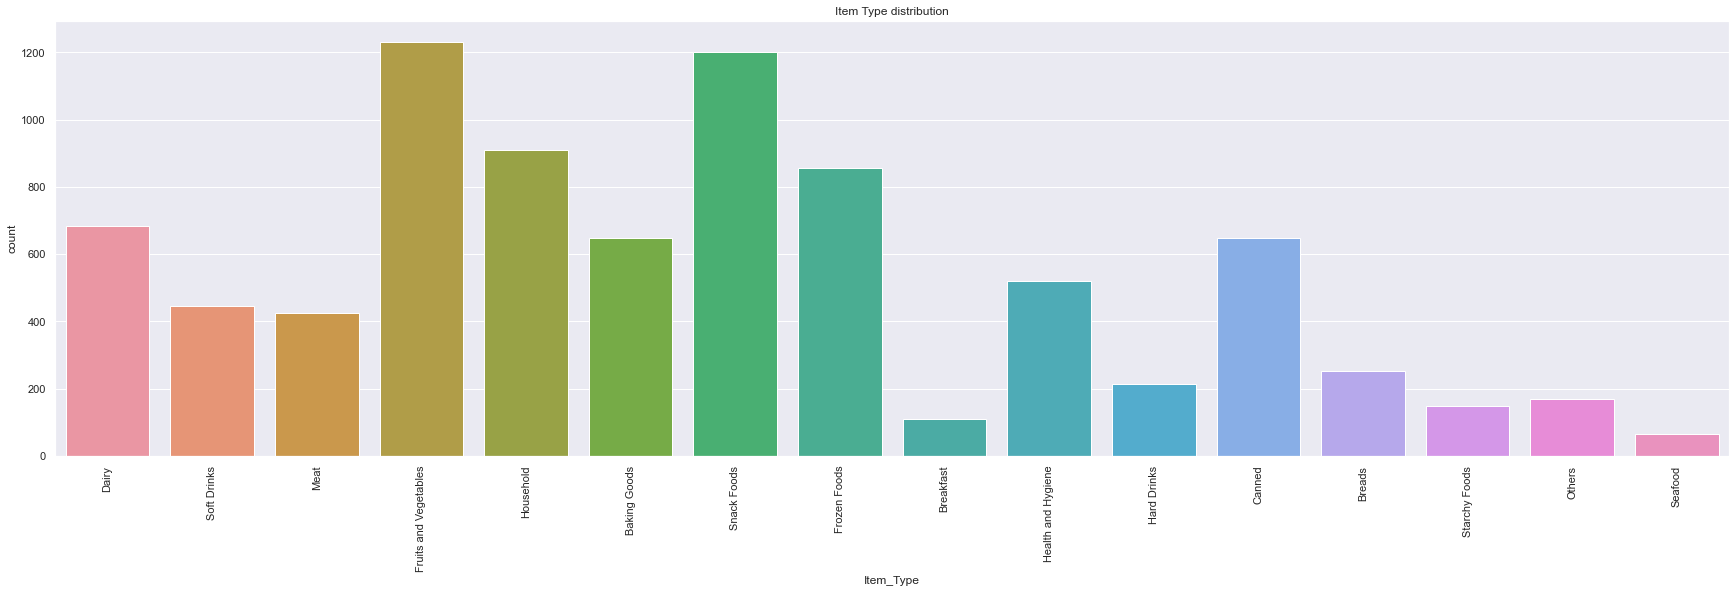

In [30]:
plt.figure(figsize=(30,8))
sns.countplot(x=df_sales['Item_Type'])
plt.xticks(rotation=90)
plt.title('Item Type distribution')

Text(0.5, 1.0, 'Item MRP distribution')

<Figure size 432x432 with 0 Axes>

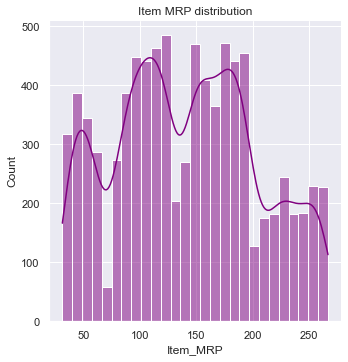

In [31]:
plt.figure(figsize=(6,6))
sns.displot(df_sales['Item_MRP'], color='purple', kde=True)
plt.title('Item MRP distribution')

Text(0.5, 1.0, 'Outlet Establishment Year')

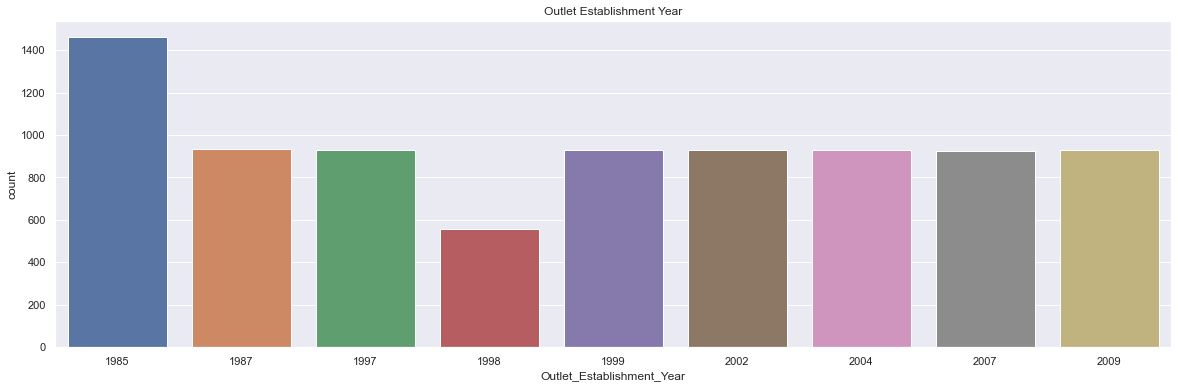

In [33]:
plt.figure(figsize=(20,6))
sns.countplot(x=df_sales['Outlet_Establishment_Year'])
plt.title('Outlet Establishment Year')

Text(0.5, 1.0, 'Outlet Size distribution')

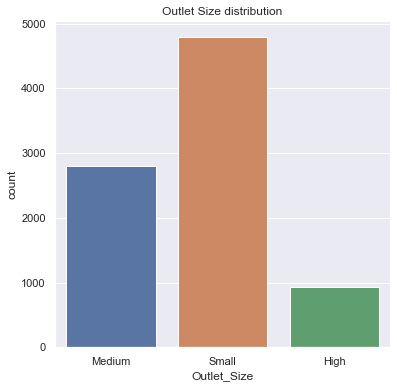

In [34]:
plt.figure(figsize=(6,6))
sns.countplot(x=df_sales['Outlet_Size'])
plt.title('Outlet Size distribution')

Text(0.5, 1.0, 'Outlet Location Type')

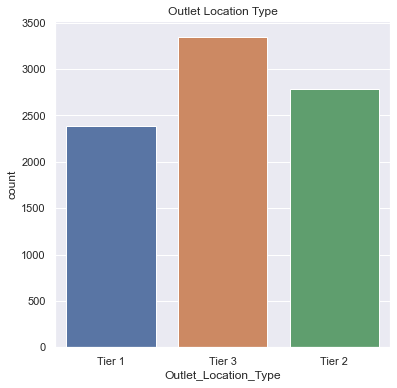

In [35]:
plt.figure(figsize=(6,6))
sns.countplot(x=df_sales['Outlet_Location_Type'])
plt.title('Outlet Location Type')

Text(0.5, 1.0, 'Outlet Type')

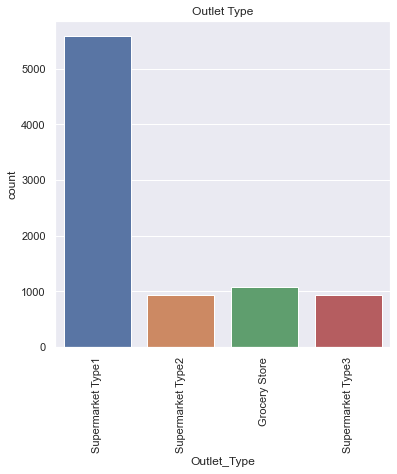

In [36]:
plt.figure(figsize=(6,6))
sns.countplot(x=df_sales['Outlet_Type'])
plt.xticks(rotation=90)
plt.title('Outlet Type')

After observing the correlation table and confirming the absence of a strong correlation between the continuous independent variables and the dependent variable (Item Outlet sales), our focus shifts to examining whether any meaningful association exists between the categorical independent (predictor) variables and the target variable.

Text(0.5, 1.0, 'relation between outlet type and target variable')

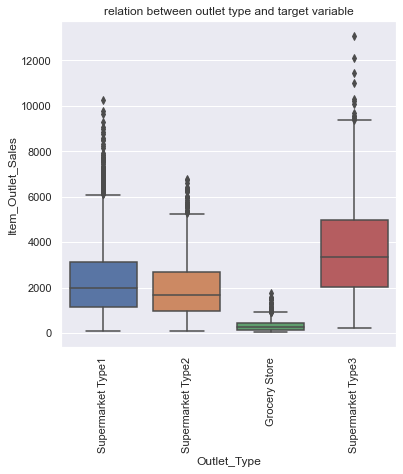

In [37]:
# checking the relationship between Outlet type and item outlet sales
plt.figure(figsize=(6,6))
sns.boxplot(x=df_sales['Outlet_Type'], y=df_sales['Item_Outlet_Sales'])
plt.xticks(rotation=90)
plt.title('relation between outlet type and target variable')

Based on the presented plot, it is evident that grocery stores exhibit the lowest item outlet sales compared to supermarket type 3, which demonstrates the highest sales. This observation suggests that outlet type can potentially be a significant factor influencing item outlet sales.

Text(0.5, 1.0, 'relation between outlet location type and target variable')

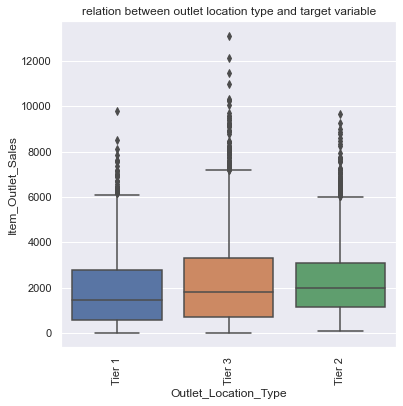

In [38]:
# checking the relationship between Outlet type and item outlet sales
plt.figure(figsize=(6,6))
sns.boxplot(x=df_sales['Outlet_Location_Type'], y=df_sales['Item_Outlet_Sales'])
plt.xticks(rotation=90)
plt.title('relation between outlet location type and target variable')

Text(0.5, 1.0, 'relation between outlet size and target variable')

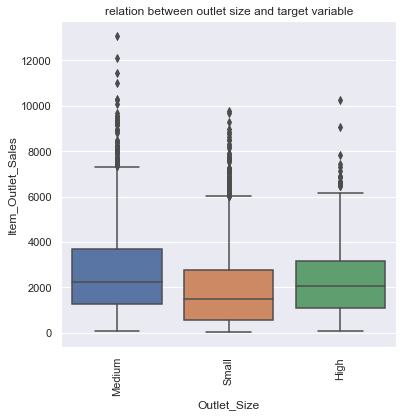

In [39]:
# checking the relationship between Outlet type and item outlet sales
plt.figure(figsize=(6,6))
sns.boxplot(x=df_sales['Outlet_Size'], y=df_sales['Item_Outlet_Sales'])
plt.xticks(rotation=90)
plt.title('relation between outlet size and target variable')

The above plot clearly illustrates a noticeable disparity in item outlet sales across different outlet location types, indicating the presence of significant variance among them.

Text(0.5, 1.0, 'Relation between item visibility and sales')

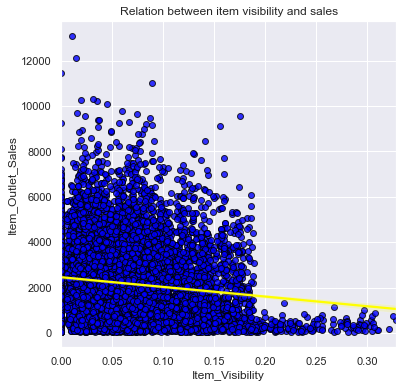

In [40]:
plt.figure(figsize=(6,6))
sns.regplot(x=df_sales['Item_Visibility'], y=df_sales['Item_Outlet_Sales'], line_kws={'color':'yellow'}, scatter_kws={'color':'blue','edgecolor':'black'})
plt.title('Relation between item visibility and sales')

Upon observing the graph above, we can discern a correlation between item visibility and sales. However, the strength of this correlation appears to be relatively weak, as evidenced by the modest slope of the line. Furthermore, it is noteworthy that this correlation demonstrates a negative relationship.

Text(0.5, 1.0, 'Relation between item MRP and sales')

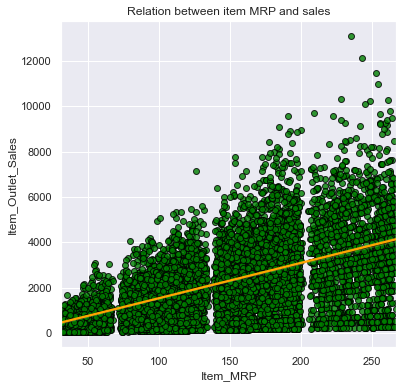

In [41]:
plt.figure(figsize=(6,6))
sns.regplot(x=df_sales['Item_MRP'], y=df_sales['Item_Outlet_Sales'], line_kws={'color':'orange'}, scatter_kws={'color':'green','edgecolor':'black'})
plt.title('Relation between item MRP and sales')

From the presented plot, it appears that there is a notable correlation between item MRP (Maximum Retail Price) and item outlet sales.

### Label Encoding:
In order to establish the relationship between categorical values and the target column, as well as to prepare the data for subsequent model fitting, we utilize label encoding. This process involves assigning a unique numerical value to each category, enabling their representation in a numeric format.

In [43]:
# initializing the encoder object
encoder=LabelEncoder()

# encoding all the categorical columns

df_sales['Item_Fat_Content']=encoder.fit_transform(df_sales['Item_Fat_Content'])
df_sales['Item_Type']=encoder.fit_transform(df_sales['Item_Type'])
df_sales['Outlet_Identifier']=encoder.fit_transform(df_sales['Outlet_Identifier'])
df_sales['Outlet_Size']=encoder.fit_transform(df_sales['Outlet_Size'])
df_sales['Outlet_Location_Type']=encoder.fit_transform(df_sales['Outlet_Location_Type'])
df_sales['Outlet_Type']=encoder.fit_transform(df_sales['Outlet_Type'])

# viewing the encoded results
df_sales.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300000,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,DRC01,5.920000,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,FDN15,17.500000,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,FDX07,19.200000,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,NCD19,8.930000,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052
5,FDP36,10.395000,1,0.000000,0,51.4008,3,2009,1,2,2,556.6088
6,FDO10,13.650000,1,0.012741,13,57.6588,1,1987,0,2,1,343.5528
7,FDP10,12.857645,0,0.127470,13,107.7622,5,1985,1,2,3,4022.7636
8,FDH17,16.200000,1,0.016687,5,96.9726,7,2002,2,1,1,1076.5986
9,FDU28,19.200000,1,0.094450,5,187.8214,2,2007,2,1,1,4710.5350


### Model Selection and Prediction:

Within this section, we will explore various regression models and assess their performance based on their ability to minimize prediction errors.

The models considered for evaluation include:


1. Simple Linear Regression
2. Multiple Linear Regression
3. XGB Regressor
4. Polynomial Regression
5. Decision Tree Regressor

By employing these models, we aim to identify the one that yields the most favorable outcomes in terms of minimizing prediction errors.

In [44]:
X=df_sales.drop(columns=['Item_Identifier','Item_Outlet_Sales'], axis=1)
Y= df_sales['Item_Outlet_Sales']

X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.2, random_state=2)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(6818, 10) (6818,)
(1705, 10) (1705,)


### 1. Simple Linear regression
Based on the correlation table, we observed a certain level of connection between the item MRP and item outlet sales. Consequently, I will examine whether it is possible to predict the target variable solely using this feature.

In [45]:
# initializing the model
lr=LinearRegression()
X_train_lr=X_train['Item_MRP'].values.reshape(-1,1)
X_test_lr=X_test['Item_MRP'].values.reshape(-1,1)

# fitting the model
lr.fit(X_train_lr, Y_train)

# testing the model for prediction
Y_hat=lr.predict(X_test_lr)
Y_hat

array([1138.89991801, 3819.01397247, 1335.43274478, ..., 2657.03651336,
       3972.39341037, 3532.02332179])

In [47]:
# evaluating the model
r2_lr=lr.score(X_test_lr,Y_test)
mae_lr=mean_absolute_error(Y_test,Y_hat)
mse_lr=mean_squared_error(Y_test,Y_hat)

print(f'The R2 value is": {r2_lr}')
print(f'The mean absolute error is: {mae_lr}')
print(f'The mean squared error is: {mse_lr}')

The R2 value is": 0.29501134495267944
The mean absolute error is: 1082.3860561273118
The mean squared error is: 2176352.648161309


Based on the results obtained, it is evident that simple linear regression is not an optimal model for prediction. Both the mean absolute error and mean squared error demonstrate significantly high values.

Additionally, conducting simple linear regression on other features is futile since their correlation values with the target variable are lower compared to that of Item_MRP.

###  2. Multiple Linear regression

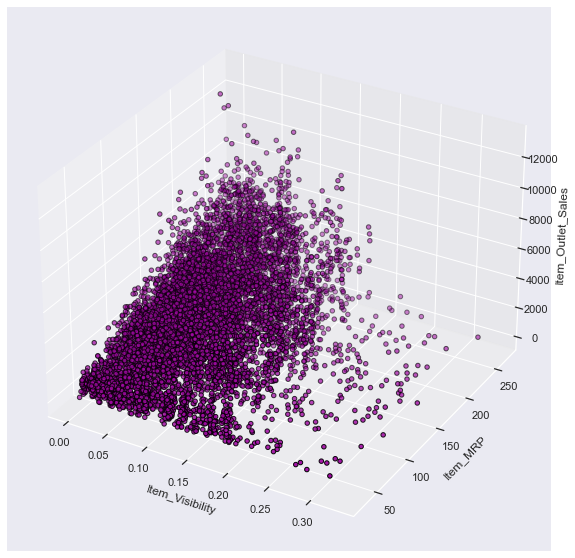

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sales['Item_Visibility'], df_sales['Item_MRP'], df_sales['Item_Outlet_Sales'], color='#a10aa3', edgecolor='black')
ax.set_xlabel('Item_Visibility')
ax.set_ylabel('Item_MRP')
ax.set_zlabel('Item_Outlet_Sales')
plt.show()

By examining this plot, it becomes apparent that item outlet sales tend to increase as item visibility decreases and item MRP increases. Therefore, these numerical factors hold substantial importance when it comes to feature selection in multiple regression.

In [49]:
# initializing the model
mlr=LinearRegression()

# fitting the model
mlr.fit(X_train,Y_train)

# making predictions
Y_hat_mlr=mlr.predict(X_test)

In [50]:
# evaluating the model
r2_mlr=mlr.score(X_test,Y_test)
mae_mlr=mean_absolute_error(Y_test,Y_hat_mlr)
mse_mlr=mean_squared_error(Y_test,Y_hat_mlr)

print(f'The R2 value is": {r2_mlr}')
print(f'The mean absolute error is: {mae_mlr}')
print(f'The mean squared error is: {mse_mlr}')


The R2 value is": 0.48913213984900805
The mean absolute error is: 944.8766216025635
The mean squared error is: 1577087.2514614917


Comparatively, the multiple Linear Regression model outperformed the simple linear regression model. However, it did not meet the desired threshold as the errors remain high, and the R2 value remains low.

### 3. Polynomial regression

In [51]:
#initializing the model
pf=PolynomialFeatures(degree=3)
pf_X_train=pf.fit_transform(X_train)
pf_X_test=pf.fit_transform(X_test)

plr=LinearRegression()

# fitting the resgrssor
plr.fit(pf_X_train,Y_train)

# predicting the results
Y_hat_plr=plr.predict(pf_X_test)

In [52]:
# evaluating the model
r2_plr=plr.score(pf_X_test,Y_test)
mae_plr=mean_absolute_error(Y_test,Y_hat_plr)
mse_plr=mean_squared_error(Y_test,Y_hat_plr)

print(f'The R2 value is": {r2_plr}')
print(f'The mean absolute error is: {mae_plr}')
print(f'The mean squared error is: {mse_plr}')

The R2 value is": 0.5823942031237672
The mean absolute error is: 792.0547983135681
The mean squared error is: 1289180.2944801971


Based on the observed results, polynomial regression demonstrates significantly improved performance, particularly when the degree hyperparameter is set to 3. This configuration yields the highest scores achieved thus far.

### 4. Random Forest Regressor

In [53]:
# initializing the regressor
rfr=RandomForestRegressor(max_depth=7, min_samples_split=5,n_estimators=100)
# fitting the resgrssor
rfr.fit(X_train,Y_train)

# predicting the results
Y_hat_rfr=rfr.predict(X_test)
Y_hat_rfr


array([2253.94482474, 3905.35618702, 1451.13244979, ..., 2855.08880196,
       3405.83504311, 3851.71249116])

In [54]:
# evaluating the model
r2_rfr=mlr.score(X_test,Y_test)
mae_rfr=mean_absolute_error(Y_test,Y_hat_rfr)
mse_rfr=mean_squared_error(Y_test,Y_hat_rfr)

print(f'The R2 value is": {r2_rfr}')
print(f'The mean absolute error is: {mae_rfr}')
print(f'The mean squared error is: {mse_rfr}')


The R2 value is": 0.48913213984900805
The mean absolute error is: 792.3007582116549
The mean squared error is: 1298781.4509368415


### 5. XGboost regression

In [57]:
# initializing the regressor
xgb=XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=500)

# fitting the resgrssor
xgb.fit(X_train,Y_train)

# predicting the results
Y_hat_xgb=xgb.predict(X_test)
Y_hat_xgb


array([2166.462 , 3899.9702, 1398.81  , ..., 2845.7095, 3413.353 ,
       3875.2478], dtype=float32)

In [58]:
# evaluating the model
r2_xgb=mlr.score(X_test,Y_test)
mae_xgb=mean_absolute_error(Y_test,Y_hat_xgb)
mse_xgb=mean_squared_error(Y_test,Y_hat_xgb)

print(f'The R2 value is": {r2_xgb}')
print(f'The mean absolute error is: {mae_xgb}')
print(f'The mean squared error is: {mse_xgb}')

The R2 value is": 0.48913213984900805
The mean absolute error is: 788.5673865307367
The mean squared error is: 1278648.3400356187


## Model Comparision

Within this section, our objective is to compare the various models implemented in the preceding sections in order to determine the most effective one. This entails:


- Comparing the models based on errors and accuracy scores.
- Generating plots to visually assess and identify the best-performing model.


In [59]:
error_dict={'Linear regression':[r2_lr,mae_lr, mse_lr], 'Multiple Linear Regression': [r2_mlr,mae_mlr,mse_mlr],
                    'Polynomial Regression': [r2_plr,mae_plr, mse_plr], 'Random Forest Regressor': [r2_rfr,mae_rfr,mse_rfr],
                   'XGBoost regressor': [r2_xgb,mae_xgb,mse_xgb]}
df_error=pd.DataFrame(error_dict, index=['R2 score','MAE','MSE'])
df_error=df_error.applymap(lambda x: round(x,2))
df_error


,Linear regression,Multiple Linear Regression,Polynomial Regression,Random Forest Regressor,XGBoost regressor
R2 score,0.30,0.49,0.58,0.49,0.49
MAE,1082.39,944.88,792.05,792.30,788.57
MSE,2176352.65,1577087.25,1289180.29,1298781.45,1278648.34


Text(0, 0.5, 'Mean squared error')

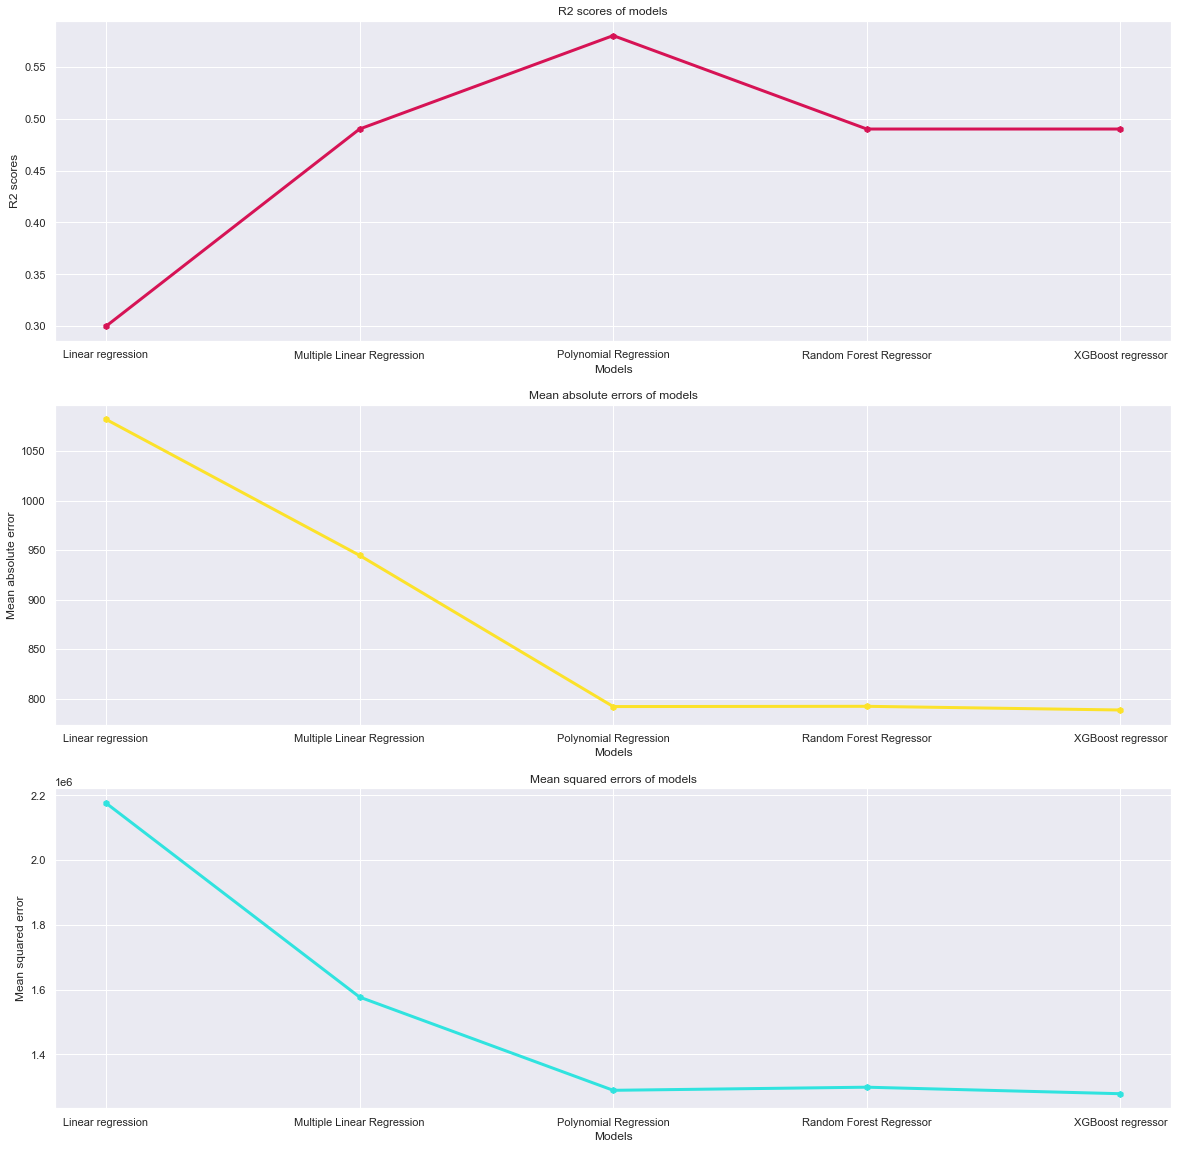

In [60]:
fig, [ax0,ax1,ax2]=plt.subplots(figsize=(20,20),nrows=3, ncols=1)

ax0.plot(df_error.columns, df_error.loc['R2 score'], marker='h', color='#D61355', linewidth=3)
ax0.set_title('R2 scores of models')
ax0.set_xlabel('Models')
ax0.set_ylabel('R2 scores')

ax1.plot(df_error.columns, df_error.loc['MAE'], marker='h', color='#FCE22A', linewidth=3)
ax1.set_title('Mean absolute errors of models')
ax1.set_xlabel('Models')
ax1.set_ylabel('Mean absolute error')

ax2.plot(df_error.columns, df_error.loc['MSE'], marker='h', color='#30E3DF', linewidth=3)
ax2.set_title('Mean squared errors of models')
ax2.set_xlabel('Models')
ax2.set_ylabel('Mean squared error')

#### Based on the aforementioned graphs, we can conclude that polynomial regression yields the most favorable results in terms of the R2 score (0.58), mean absolute error (792.05), and mean squared error (1289179.98). Consequently, we will select this model for making predictions.